In [2]:
import getpass
import pandas as pd
from sqlalchemy import create_engine
import toolz as t
 
driver = 'mssql+pymssql'
username = 'SAVVYSHERPA\\{}'.format(getpass.getuser())
hostname = 'devsql10'
port = 1433
database = 'pdb_IMPACT'
 
db = create_engine('%s://%s:%s@%s:%d/%s' %(driver, username, getpass.getpass(), hostname, port, database))

········


In [83]:
# from savvycgm.CGM_utils import *
import time
import functools
from datetime import datetime
from statistics import mode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy.interpolate import interp1d
from pandas.tseries.holiday import USFederalHolidayCalendar as hol_calendar
from sklearn.externals import joblib as jl
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix as cf
import scipy.signal as ss
from scipy.signal import butter, lfilter, freqz
import calendar
import datetime as dt
from scipy import stats as st
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans as km
from sklearn import svm
# from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf, pacf
%matplotlib inline
from sqlalchemy import Table, MetaData
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score as cv_score

In [4]:
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_curve as roc
from sklearn.model_selection import cross_val_score as cvs
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.ensemble import GradientBoostingClassifier as GradBoosting
from sklearn.ensemble import ExtraTreesClassifier as ExtraTrees
from sklearn.metrics import auc as auc
from sklearn.datasets import make_classification 

In [5]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
#     import matplotlib.pyplot as plt
#     import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [6]:
pd.options.display.max_columns = 999

In [7]:
tables= db.table_names()
tables

['_Commercial_IpClaims',
 'Commercial_DrClaims',
 'Commercial_Members',
 'Commercial_OpClaims',
 'Commercial_RxClaims',
 'DiagnosisCrossWalk',
 'ICD9_to_ICD10',
 'Medicare_DrClaims',
 'Medicare_ID',
 'Medicare_IpClaims',
 'Medicare_Members',
 'Medicare_OpClaims',
 'Medicare_RxClaims',
 'OP_Diab_Members',
 'Taxonomy',
 'XETL_Medicare_ID']

### Load Data

In [5]:
pd_CW = pd.read_sql('SELECT * FROM DiagnosisCrossWalk', db)
pd_CW = pd_CW.set_index(pd_CW.DIAG_CD)

In [6]:
pd_Dr = pd.read_sql('SELECT RandomMbrID, FULL_DT, Diag_CD_1, \
Diag_CD_2,  \
Diag_CD_3, Allw_Amt FROM Commercial_DrClaims', db)

In [7]:
pd_Dr.shape

(7291057, 6)

In [8]:
pd_Dr['Table'] = pd.DataFrame(['DR']*pd_Dr.shape[0], columns = ['Table'])

In [9]:
pd_Dr.head(2)

,RandomMbrID,FULL_DT,Diag_CD_1,Diag_CD_2,Diag_CD_3,Allw_Amt,Table
0,10,2014-07-09,V7231,,,4.24,DR
1,10,2014-07-15,4770,,,14.50,DR


In [10]:
pd_Op = pd.read_sql('SELECT RandomMbrID, FULL_DT, Diag_CD_1, \
Diag_CD_2,  \
Diag_CD_3, Allw_Amt FROM Commercial_OpClaims', db)

In [11]:
pd_Op['Table'] = pd.DataFrame(['OP']*pd_Op.shape[0], columns = ['Table'])

In [12]:
pd_Op.head(2)

,RandomMbrID,FULL_DT,Diag_CD_1,Diag_CD_2,Diag_CD_3,Allw_Amt,Table
0,10,2014-07-09,V770,V771,V7791,2.81,OP
1,10,2014-07-09,V770,V771,V7791,12.03,OP


In [13]:
pd_Ip = pd.read_sql('SELECT RandomMbrID, FULL_DT, Diag_CD_1, \
Diag_CD_2,  \
Diag_CD_3, Allw_Amt FROM _Commercial_IpClaims', db)

In [14]:
pd_Ip['Table'] = pd.DataFrame(['IP']*pd_Ip.shape[0], columns = ['Table'])

In [15]:
pd_Ip.head(2)

,RandomMbrID,FULL_DT,Diag_CD_1,Diag_CD_2,Diag_CD_3,Allw_Amt,Table
0,1000024,2015-11-03,F333,F419,F909,0.0,IP
1,1000024,2015-11-03,F333,F419,F909,2700.0,IP


### Merge Data

In [16]:
pd_All = pd.concat([pd_Dr, pd_Op, pd_Ip], axis = 0)

In [17]:
pd_All

,RandomMbrID,FULL_DT,Diag_CD_1,Diag_CD_2,Diag_CD_3,Allw_Amt,Table
0,10,2014-07-09,V7231,,,4.24,DR
1,10,2014-07-15,4770,,,14.50,DR
2,10,2014-06-18,4770,,,14.50,DR
3,10,2014-03-12,4770,,,14.50,DR
4,10,2014-12-19,4770,,,14.50,DR
5,10,2014-04-02,4770,,,14.50,DR
6,10,2014-08-12,4770,,,14.50,DR
7,10,2014-02-12,4770,,,14.50,DR
8,10,2014-02-26,4770,,,14.50,DR
9,10,2014-08-26,4770,,,14.50,DR


In [18]:
pd_All['AHRQ_1'] = pd_All.Diag_CD_1.map(pd_CW.AHRQ_DIAG_DTL_CATGY_CD).convert_objects(convert_numeric = True)
pd_All['AHRQ_2'] = pd_All.Diag_CD_2.map(pd_CW.AHRQ_DIAG_DTL_CATGY_CD).convert_objects(convert_numeric = True)
pd_All['AHRQ_3'] = pd_All.Diag_CD_3.map(pd_CW.AHRQ_DIAG_DTL_CATGY_CD).convert_objects(convert_numeric = True)

/home/xpuspus/.conda/envs/cgm-research/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':
/home/xpuspus/.conda/envs/cgm-research/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app
/home/xpuspus/.conda/envs/cgm-research/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


In [19]:
pd_All.head(2)

,RandomMbrID,FULL_DT,Diag_CD_1,Diag_CD_2,Diag_CD_3,Allw_Amt,Table,AHRQ_1,AHRQ_2,AHRQ_3
0,10,2014-07-09,V7231,,,4.24,DR,256.0,NaN,NaN
1,10,2014-07-15,4770,,,14.50,DR,134.0,NaN,NaN


In [20]:
pd_All['Year'], pd_All['Month'], pd_All['Day'] = pd_All.FULL_DT.apply(lambda x: x.split('-')[0]).astype(int), pd_All.FULL_DT.apply(lambda x: x.split('-')[1]).astype(int), pd_All.FULL_DT.apply(lambda x: x.split('-')[2]).astype(int)

In [21]:
pd_All.head(2)

,RandomMbrID,FULL_DT,Diag_CD_1,Diag_CD_2,Diag_CD_3,Allw_Amt,Table,AHRQ_1,AHRQ_2,AHRQ_3,Year,Month,Day
0,10,2014-07-09,V7231,,,4.24,DR,256.0,NaN,NaN,2014,7,9
1,10,2014-07-15,4770,,,14.50,DR,134.0,NaN,NaN,2014,7,15


### Merge Continuously-enrolled Member data 

In [22]:
pd_Mem = pd.read_sql("SELECT RandomMbrID, Gdr_Cd, Age FROM Commercial_Members \
WHERE Commercial_Members.MM_2014 = 12 and Commercial_Members.MM_2015 = 12 and Commercial_Members.MM_2016 = 12", db)

In [23]:
pd_Mem.head(2)

,RandomMbrID,Gdr_Cd,Age
0,886552,M,50
1,888328,F,35


In [24]:
pd_All = functools.reduce(lambda left, right: pd.merge(left, right, on = ['RandomMbrID']), [pd_Mem, pd_All])

### Fill NaN with 9999

In [25]:
pd_All.AHRQ_1 = pd_All.AHRQ_1.fillna(9999)
pd_All.AHRQ_2 = pd_All.AHRQ_2.fillna(9999)
pd_All.AHRQ_3 = pd_All.AHRQ_3.fillna(9999)

In [26]:
pd_All.head(2)

,RandomMbrID,Gdr_Cd,Age,FULL_DT,Diag_CD_1,Diag_CD_2,Diag_CD_3,Allw_Amt,Table,AHRQ_1,AHRQ_2,AHRQ_3,Year,Month,Day
0,886552,M,50,2015-05-13,71946,,,3.35,DR,204.0,9999.0,9999.0,2015,5,13
1,886552,M,50,2015-02-27,71536,71946,,102.09,DR,203.0,204.0,9999.0,2015,2,27


### Onehot AHRQs

In [27]:
pd_All_onehot_AHRQ1 = pd.get_dummies(pd_All.AHRQ_1.astype(int))
pd_All_onehot_AHRQ2 = pd.get_dummies(pd_All.AHRQ_2.astype(int))
pd_All_onehot_AHRQ3 = pd.get_dummies(pd_All.AHRQ_3.astype(int))

In [28]:
pd_All_onehot_Table = pd.get_dummies(pd_All.Table)

### Concatenate Member Data and Onehots

In [59]:
pd_Diab_1 = pd.concat([pd_All[['RandomMbrID','Year', 'Month', 'Day', 'Allw_Amt','Gdr_Cd','Age']], pd_All_onehot_AHRQ1, \
                       pd_All_onehot_Table], axis = 1)

In [60]:
pd_Diab_1['is_Diab'] = pd_All_onehot_AHRQ1[49] == 1

In [77]:
pd_Diab_1['Gdr'] = pd_Diab_1.Gdr_Cd == 'M'

In [79]:
pd_Diab_1 = pd_Diab_1.drop(['Gdr_Cd'], axis = 1)

In [80]:
pd_Diab_1.head(2)

,RandomMbrID,Year,Month,Day,Allw_Amt,Age,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,650,651,652,653,654,655,656,657,658,659,660,661,662,663,670,999,2603,2607,2608,2609,2610,2611,2617,9999,DR,IP,OP,is_Diab,Gdr
0,886552,2015,5,13,3.35,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,True
1,886552,2015,2,27,102.09,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,True


### Choose all members without diabetes for all years

In [82]:
no_diab = pd_Diab_1[pd_Diab_1.is_Diab == 0]

In [83]:
no_diab_2016 = no_diab[no_diab['Year'] == 2016]

In [84]:
no_diab_not_2016 = no_diab[no_diab['Year'] != 2016]

In [85]:
mmbr_no_diab_not_2016 = no_diab_not_2016.RandomMbrID.unique()
mmbr_no_diab_not_2016

array(['886552', '888328', '886639', ..., '528331', '530122', '1062226'], dtype=object)

In [86]:
mmbr_no_diab_2016 = no_diab_2016.RandomMbrID.unique()
mmbr_no_diab_2016

array(['886552', '888328', '886621', ..., '707146', '530122', '1062226'], dtype=object)

In [87]:
mmbr_no_diab_all_years = np.array([elem for elem in mmbr_no_diab_2016 if elem in mmbr_no_diab_not_2016])

In [88]:
mmbr_no_diab_all_years

array(['886552', '888328', '886621', ..., '528331', '530122', '1062226'], 
      dtype='<U7')

### Choose all members with diabetes

In [89]:
all_diab = pd_Diab_1[pd_Diab_1.is_Diab == 1]

In [90]:
all_diab_2016 = all_diab[all_diab['Year'] == 2016]

In [91]:
all_diab_not_2016 = all_diab[all_diab['Year'] != 2016 ]

In [92]:
mmbr_diab_not_2016 = all_diab_not_2016.RandomMbrID.unique()
mmbr_diab_not_2016

array(['888649', '887278', '1061797', ..., '827533', '827182', '528331'], dtype=object)

In [93]:
mmbr_diab_2016 = all_diab_2016.RandomMbrID.unique()
mmbr_diab_2016

array(['886621', '887977', '888649', ..., '826579', '827533', '528331'], dtype=object)

### Filter the ones diagnosed with diabetes in 2016 and none in 2014 and 2015

In [94]:
mmbr_diab_only_2016 = np.array([elem for elem in mmbr_diab_2016 if elem not in mmbr_diab_not_2016])

In [95]:
mmbr_diab_only_2016

array(['886621', '887977', '888733', ..., '826891', '826651', '827257'], 
      dtype='<U7')

In [96]:
diab_only_2016_df = pd.DataFrame(mmbr_diab_only_2016, columns = ['RandomMbrID'])

In [97]:
no_diab_all_years_df = pd.DataFrame(mmbr_no_diab_all_years, columns = ['RandomMbrID'])

In [98]:
no_diabs = no_diab_all_years_df.merge(pd_Diab_1[pd_Diab_1['Year'] != 2016], on = 'RandomMbrID')

In [99]:
diabs = diab_only_2016_df.merge(pd_Diab_1[pd_Diab_1['Year'] != 2016], on='RandomMbrID')

In [100]:
no_diabs.head(2)

,RandomMbrID,Year,Month,Day,Allw_Amt,Age,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,650,651,652,653,654,655,656,657,658,659,660,661,662,663,670,999,2603,2607,2608,2609,2610,2611,2617,9999,DR,IP,OP,is_Diab,Gdr
0,886552,2015,5,13,3.35,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,True
1,886552,2015,2,27,102.09,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,True


In [101]:
diabs.head(2)

,RandomMbrID,Year,Month,Day,Allw_Amt,Age,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,650,651,652,653,654,655,656,657,658,659,660,661,662,663,670,999,2603,2607,2608,2609,2610,2611,2617,9999,DR,IP,OP,is_Diab,Gdr
0,886621,2014,6,16,59.59,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
1,886621,2014,10,8,14.37,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False


In [104]:
print(no_diabs.shape[0], diabs.shape[0])

2890010 90376


### Create dataset

In [131]:
X = pd.concat([no_diabs, diabs], axis =0)

In [132]:
X = X.drop(['RandomMbrID', 'Year', 'Month', 'Day'], axis = 1)

In [133]:
# X.to_pickle('X_diab.pkl')

In [8]:
X = pd.read_pickle('X_diab.pkl')

In [9]:
no = 2890010
di = 90376

In [127]:
di*1./ no * 100


3.1271864111196845

In [10]:
y = np.concatenate([np.array([0]*no), np.array([1]*di)])

In [131]:
X[y == 1]['Age'].as_matrix()

array(['59', '59', '59', ..., '54', '54', '54'], dtype=object)

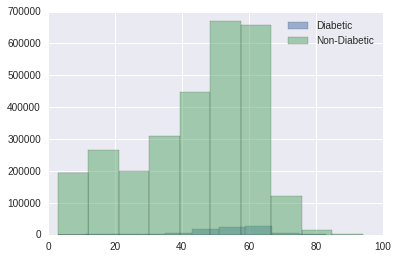

In [135]:
plt.hist(X[y == 1]['Age'].as_matrix().astype(float), alpha = 0.5, label = 'Diabetic')
plt.hist(X[y == 0]['Age'].as_matrix().astype(float), alpha = 0.5, label = 'Non-Diabetic')
plt.legend()

(array([ 194156.,  266429.,  199285.,  309583.,  448793.,  671003.,
         659300.,  121971.,   16149.,    3341.]),
 array([  3. ,  12.1,  21.2,  30.3,  39.4,  48.5,  57.6,  66.7,  75.8,
         84.9,  94. ]),
 <a list of 10 Patch objects>)

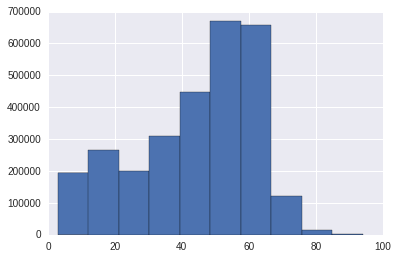

In [134]:
plt.hist(X[y == 0]['Age'].as_matrix().astype(float))

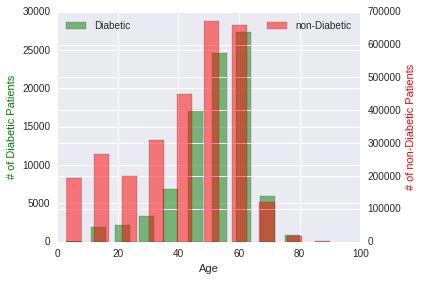

In [186]:

fig, ax1 = plt.subplots()
ax1.hist(X[y == 1]['Age'].as_matrix().astype(float), alpha = 0.5, label = 'Diabetic', color = 'g', width = 5)

ax1.set_ylabel('# of Diabetic Patients', color='g')
ax1.set_xlabel('Age')
ax1.legend(loc  =2)
ax2 = ax1.twinx()
ax2.hist(X[y == 0]['Age'].as_matrix().astype(float), alpha = 0.5, label = 'non-Diabetic', color='r', width = 5)
ax2.set_ylabel('# of non-Diabetic Patients', color='r')
# ax2.set_ylim(0, 1)
ax2.set_xlabel('Age')
fig.tight_layout()
ax2.legend(loc = 1)
plt.show()

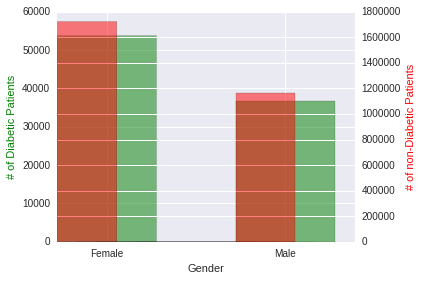

In [188]:

fig, ax1 = plt.subplots()
ax1.hist(X[y == 1]['Gdr'].as_matrix().astype(int), alpha = 0.5, label = 'Diabetic', color = 'g', width = .5)
ax1.set_xticks([0.25, 1.15])

ax1.set_ylabel('# of Diabetic Patients', color='g')
ax1.set_xlabel('Gender')
# ax1.set_ylim(0, 1)
ax1.set_xlim(0, 1.5)
ax1.set_xticklabels(['Female', 'Male'])
ax2 = ax1.twinx()
ax2.hist(X[y == 0]['Gdr'].as_matrix().astype(int), alpha = 0.5, label = 'non-Diabetic', color='r', width = .3)
ax2.set_ylabel('# of non-Diabetic Patients', color='r')
# ax2.set_ylim(0, 1)
ax2.set_xlabel('Gender')
ax2.set_xlim(0, 1.5)
ax2.set_xticklabels(['Female', 'Male'])
fig.tight_layout()
# ax2.legend(loc = )
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [12]:
sm = SMOTE(random_state = 42)

In [13]:
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

### Logistic Regression

In [138]:
logr_res = LogR()

In [139]:
logr_res.fit(X_train_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [140]:
pred_res = logr_res.predict(X_test)

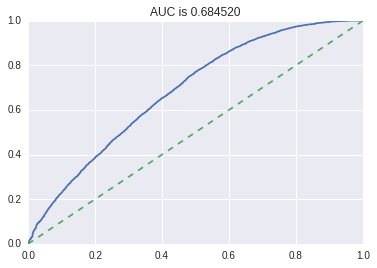

In [141]:
pred_proba_res = logr_res.predict_proba(X_test)
fpr, tpr, _ = roc(y_test, pred_proba_res[:,1])
plt.plot(fpr, tpr)
plt.plot(np.linspace(0, 1, fpr.shape[0]), np.linspace(0, 1, fpr.shape[0]), '--')
plt.title('AUC is %f' % auc(fpr, tpr))
plt.show()

In [142]:
np.mean(pred_res == y_test)

0.57465598013681107

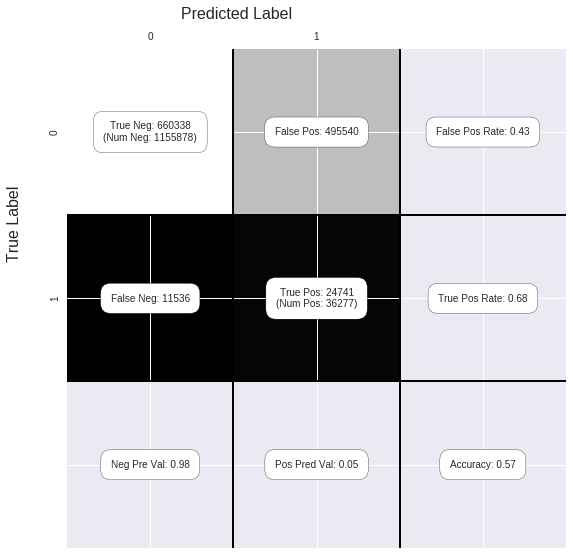

In [ ]:
show_confusion_matrix(cf(y_test, pred_res))

### Extra Trees Classifier

In [27]:
time_ext = time.time()
extra_res = ExtraTrees(n_estimators = 50)
extra_res.fit(X_train_res, y_train_res)
extra_pred = extra_res.predict(X_test)
fpr, tpr, _ = roc(y_test, extra_pred)
print('run time', time.time() - time_ext)

run time 11227.221091985703


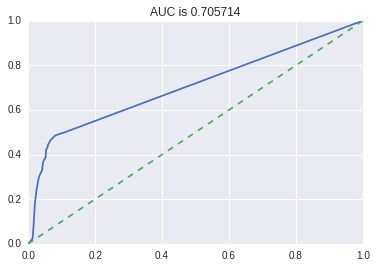

run time 120.00023627281189


In [28]:
time_ext_prob = time.time()
pred_proba_res_ext = extra_res.predict_proba(X_test)
fpr, tpr, _ = roc(y_test, pred_proba_res_ext[:,1])
plt.plot(fpr, tpr)
plt.plot(np.linspace(0, 1, fpr.shape[0]), np.linspace(0, 1, fpr.shape[0]), '--')
plt.title('AUC is %f' % auc(fpr, tpr))
plt.show()
print('run time', time.time() - time_ext_prob)

In [29]:
np.mean(y_test == extra_pred)

0.93967311297608114

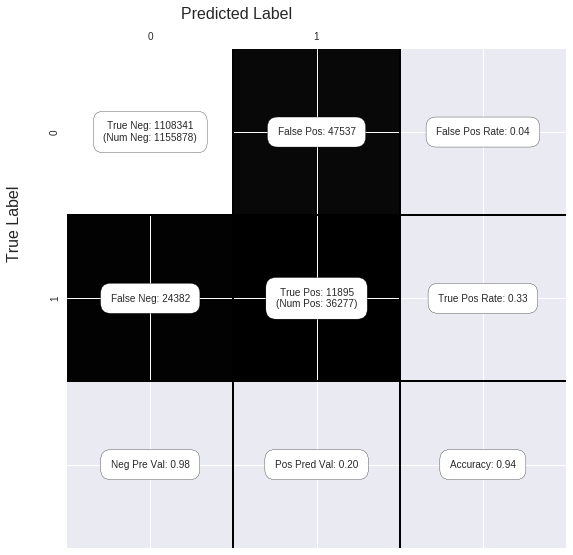

In [30]:
show_confusion_matrix(cf(y_test, extra_pred))

### Random Forest

In [21]:
time_rf = time.time()
rf = RF(n_estimators = 100)
rf.fit(X_train_res, y_train_res)
rf_pred = rf.predict(X_test)
fpr, tpr, _ = roc(y_test, rf_pred)
print(time.time() - time_rf)

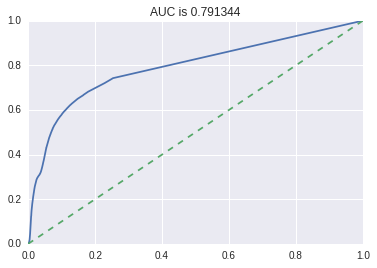

In [23]:
pred_proba_res_rf = rf.predict_proba(X_test)
fpr, tpr, _ = roc(y_test, pred_proba_res_rf[:,1])
plt.plot(fpr, tpr)
plt.plot(np.linspace(0, 1, fpr.shape[0]), np.linspace(0, 1, fpr.shape[0]), '--')
plt.title('AUC is %f' % auc(fpr, tpr))
plt.show()

In [24]:
np.mean(y_test == rf_pred)

0.94041462729259195

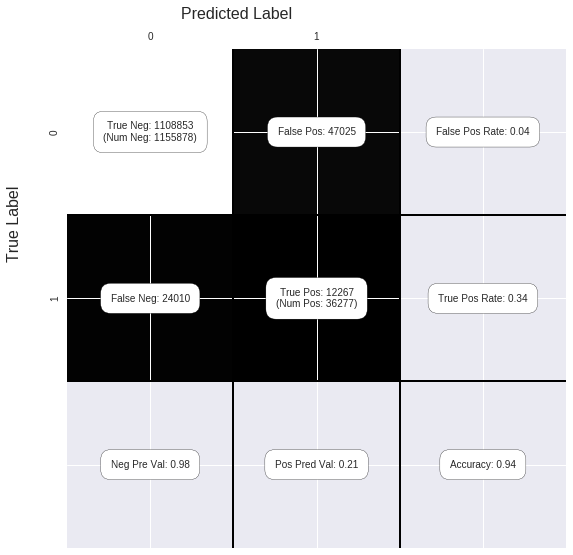

In [25]:
show_confusion_matrix(cf(y_test, rf_pred))

### Important Features

Feature ranking:
1. feature 1 (0.262418)
2. feature 0 (0.207336)
3. feature 277 (0.058667)
4. feature 269 (0.022546)
5. feature 273 (0.020020)
6. feature 275 (0.018437)
7. feature 194 (0.013650)
8. feature 88 (0.013329)
9. feature 245 (0.013300)
10. feature 200 (0.011734)
11. feature 247 (0.011377)
12. feature 116 (0.011185)
13. feature 54 (0.010116)
14. feature 193 (0.009983)
15. feature 248 (0.009739)
16. feature 51 (0.008735)
17. feature 240 (0.008544)
18. feature 92 (0.008481)
19. feature 147 (0.007451)
20. feature 11 (0.007378)
21. feature 221 (0.006545)
22. feature 85 (0.006452)
23. feature 189 (0.006378)
24. feature 192 (0.006282)
25. feature 49 (0.006001)
26. feature 123 (0.005511)
27. feature 48 (0.004986)
28. feature 276 (0.004741)
29. feature 246 (0.004739)
30. feature 124 (0.004527)
31. feature 144 (0.004481)
32. feature 274 (0.004380)
33. feature 50 (0.004275)
34. feature 96 (0.004159)
35. feature 30 (0.004074)
36. feature 201 (0.003981)
37. feature 156 (0.003928)
38. feat

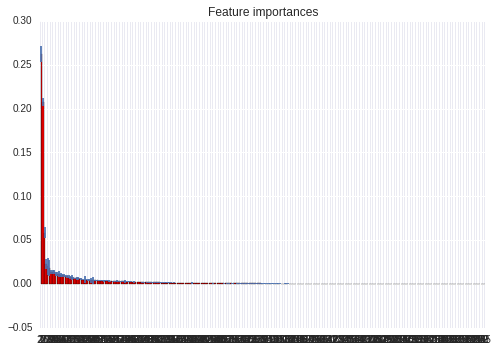

In [18]:
forest = RF(n_estimators=100)

forest.fit(X_train_res, y_train_res)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_res.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_res.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_res.shape[1]), indices)
plt.xlim([-1, X_train_res.shape[1]])
plt.show()

In [19]:
top_10_feat = np.array(X.columns)[indices[:10]]
top_10_feat

array(['Age', 'Allw_Amt', 'Gdr', 2610, 'DR', 'OP', 205, 98, 256, 211], dtype=object)

In [20]:
np.sort(importances)[::-1][:10]

array([ 0.26241818,  0.20733632,  0.05866701,  0.02254634,  0.02001961,
        0.01843674,  0.01365025,  0.01332937,  0.01329994,  0.01173355])

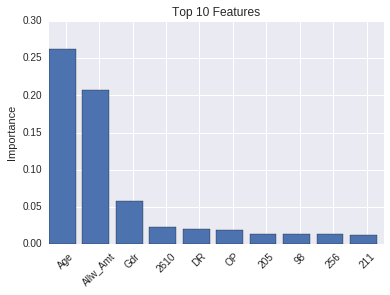

In [124]:
plt.bar(np.arange(10),np.sort(importances)[::-1][:10])
plt.title('Top 10 Features')
plt.xticks(np.arange(10)+0.5, top_10_feat, rotation = 45)
plt.ylabel('Importance')
plt.show()

In [14]:
# X_10 = X_train[top_10_feat]
# np.mean(X_10['Age'][y == 1].unique().astype(float))

In [65]:
X_10_res, y_10_res = sm.fit_sample(X_10, y_train)

In [66]:
time_rf = time.time()
rf = RF(n_estimators = 100)
rf.fit(X_10_res, y_10_res)
rf_pred = rf.predict(X_test[top_10_feat])
fpr, tpr, _ = roc(y_test, rf_pred)
print(time.time() - time_rf)

2581.5886108875275


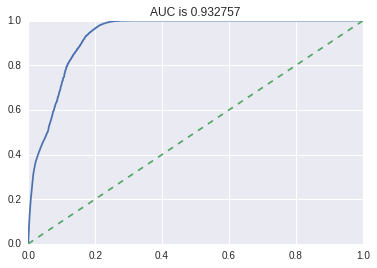

In [68]:
pred_proba_res_rf = rf.predict_proba(X_test[top_10_feat])
fpr, tpr, _ = roc(y_test, pred_proba_res_rf[:,1])
plt.plot(fpr, tpr)
plt.plot(np.linspace(0, 1, fpr.shape[0]), np.linspace(0, 1, fpr.shape[0]), '--')
plt.title('AUC is %f' % auc(fpr, tpr))
plt.show()

0.905411628521


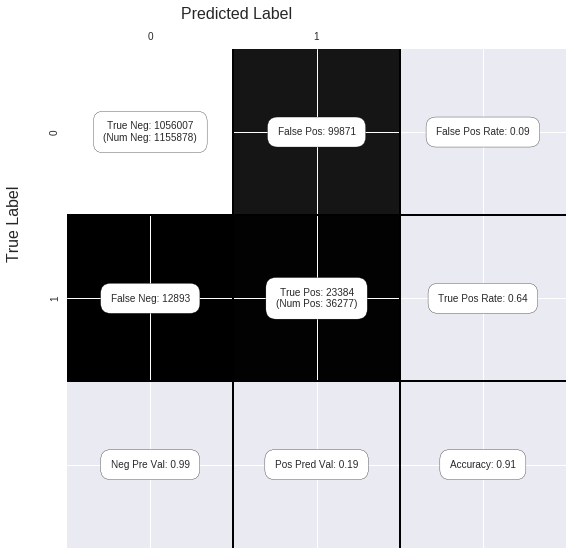

In [70]:
print(np.mean(y_test == rf_pred))
show_confusion_matrix(cf(y_test, rf_pred))

### Bagging Classifier

In [38]:
time_bc = time.time()
BC = BaggingClassifier(n_estimators = 100)
BC.fit(X_train_res, y_train_res)
BC_pred = BC.predict(X_test)
# fpr, tpr, _ = roc(y_test, rf_pred)
print(time.time() - time_bc)

31011.025112628937


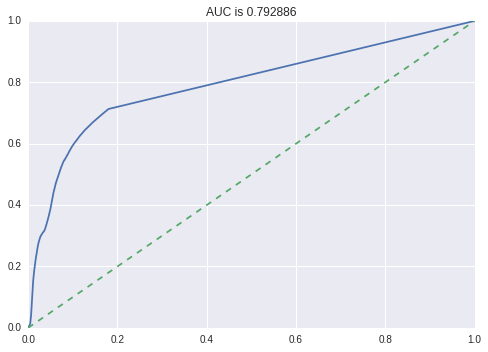

In [39]:
BC_pred = BC.predict(X_test)
pred_proba_res_bc = BC.predict_proba(X_test)
fpr, tpr, _ = roc(y_test, pred_proba_res_bc[:,1])
plt.plot(fpr, tpr)
plt.plot(np.linspace(0, 1, fpr.shape[0]), np.linspace(0, 1, fpr.shape[0]), '--')
plt.title('AUC is %f' % auc(fpr, tpr))
plt.show()

In [40]:
np.mean(y_test == BC_pred)

0.93903477316288575

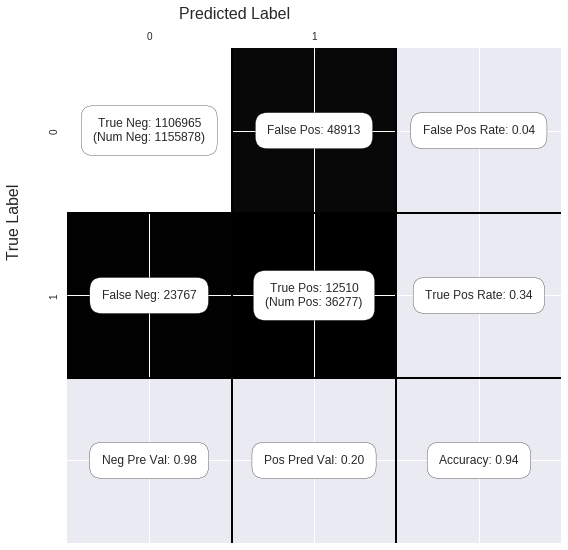

In [41]:
show_confusion_matrix(cf(y_test, BC_pred))

### Run for multiple classifiers

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 999
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, \
                             AdaBoostClassifier, \
                             GradientBoostingClassifier, \
                             ExtraTreesClassifier, \
                             BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

from sklearn.metrics import roc_curve, auc, confusion_matrix

import re

import seaborn as sns
sns.set()

from sklearn.externals import joblib as jl

In [16]:
def predict_threshold(predict_proba, threshold):
    return np.array([1 if x > threshold else 0 for x in predict_proba.T[1]])

def process_persample(classifier, train_data, train_label, test_data, test_label, th):
    mod = classifier.fit(train_data, train_label)
    probas_ = classifier.predict_proba(test_data)
    pred = predict_threshold(probas_, th)
    confusion_ = confusion_matrix(test_label, pred, labels=None)
    score = np.round(accuracy_score(test_label, pred), 3)
    fpr, tpr, thresholds = roc_curve(test_label, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return score, confusion_, [fpr, tpr, thresholds, roc_auc]

def process_classifiers(classifiers, df_train, df_test, df_validate, y_train, y_test, y_validate, th):
    
    train_f = df_train
    train_l = y_train

    test_f = df_test
    test_l = y_test
    
    validate_f = df_validate
    validate_l = y_validate
    
    index = [re.findall('\w*', str(x))[0] for x in classifier]
    
    params = {"test" : [test_f,test_l], "validate" : [validate_f,validate_l]}
    #params = {"test" : [test_f,test_l]}
    accuracy_table = []
    
    with sns.axes_style("darkgrid"):
        fig, axes = plt.subplots(int(np.ceil(9/ 3)), 3, sharex='all', sharey='all', figsize=(12, 12))

        for ax, i in zip(axes.flatten(), range(len(classifier))):
            a = []
            
            for keys in params:
                acc, conf_m, roc_ = process_persample(classifier[i], train_f, train_l, \
                                                  params[keys][0], params[keys][1], th)
                a.append(acc)
                
                x_roc = np.insert(roc_[0],0,0, axis=0)
                y_roc = np.insert(roc_[1],0,0, axis=0)
                ax.plot(x_roc, y_roc ,lw=1, label = 'ROC %s (area = %0.4f)' % (keys, roc_[3]))
        
            ax.set_title(re.findall('\w*', str(classifier[i]))[0], size = 13)
            ax.legend(loc=4, fontsize=11)
            
            accuracy_table.append(a)
            ax.set_xlim(-0.1,1.1)
            ax.set_ylim(-0.1,1.1)
            ax.axis("equal")
        
        
    
    return pd.DataFrame(np.array(accuracy_table), columns = ['test accuracy','validate_accuracy'], \
                        index = index)


classifier = [LogR(),
              DecisionTreeClassifier(),
              RandomForestClassifier(100),
              AdaBoostClassifier(), 
              GradientBoostingClassifier(),
              ExtraTreesClassifier(100),
              BaggingClassifier(),
              KNeighborsClassifier(),
              GaussianNB()
             ]
# classifier = [DecisionTreeClassifier(),
#                 AdaBoostClassifier(), 
#               GradientBoostingClassifier(),
#               BaggingClassifier(),
#              ]

### Top 10 Features Only

In [22]:
top_10_feat

array(['Age', 'Allw_Amt', 'Gdr', 2610, 'DR', 'OP', 205, 98, 256, 211], dtype=object)

In [98]:
# X_train_, X_test_, y_train_, y_test_ = train_test_split(X[top_10_feat], y, test_size = 0.4, random_state = 42)

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_train_res_, y_train_res_ = sm.fit_sample(X_train_, y_train_)

In [ ]:
pc = time.time()
process_classifiers(classifier, X_train_res_, X_test_, X_test_, y_train_res_, y_test_, y_test_, 0.5)
print ('runtime', time.time() - pc)

In [26]:
print ('runtime', time.time() - pc)

runtime 12957.480070352554


In [27]:
X.head(2)

,Allw_Amt,Age,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,650,651,652,653,654,655,656,657,658,659,660,661,662,663,670,999,2603,2607,2608,2609,2610,2611,2617,9999,DR,IP,OP,is_Diab,Gdr
0,3.35,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,True
1,102.09,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,True


In [28]:
X_AHRQ = X.drop(['Allw_Amt', 'Age', 'is_Diab', 'Gdr', 9999], axis = 1)

In [29]:
X_AHRQ.head(2)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,650,651,652,653,654,655,656,657,658,659,660,661,662,663,670,999,2603,2607,2608,2609,2610,2611,2617,DR,IP,OP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
X_demog = X[['Allw_Amt', 'Age',  'DR', 'IP', 'OP', 'Gdr']]
X_demog.head(2)

,Allw_Amt,Age,DR,IP,OP,Gdr
0,3.35,50,1.0,0.0,0.0,True
1,102.09,50,1.0,0.0,0.0,True


In [31]:
X_demog.shape

(2980386, 6)

In [32]:
feats_50 = np.array(X.columns)[indices[:50]]
feats_50

array(['Age', 'Allw_Amt', 'Gdr', 2610, 'DR', 'OP', 205, 98, 256, 211, 258,
       126, 53, 204, 259, 50, 251, 102, 158, 10, 232, 95, 200, 203, 48,
       133, 47, 'is_Diab', 257, 134, 155, 'IP', 49, 106, 29, 212, 167, 657,
       101, 171, 225, 229, 252, 24, 51, 58, 84, 163, 109, 175], dtype=object)

In [33]:
feat_vals = np.sort(importances)[::-1]
# feat_vals

In [34]:
# plt.plot(feat_vals)

In [35]:
pca = PCA(n_components=30)

In [36]:
X_pca = pca.fit_transform(X)

In [37]:
X_feats_50 = X[feats_50]

In [50]:
pca_10 = PCA(n_components = 10)
pca_20 = PCA(n_components = 20)

In [51]:
X_pca_10 = pca_10.fit_transform(X)
X_pca_20 = pca_20.fit_transform(X)

In [38]:
X_dict = {'X_feats_50':X_feats_50, 'X_pca':X_pca, 'X_demog':X_demog, 'X_AHRQ':X_AHRQ}

In [52]:
X_pcas = {'X_pca_10': X_pca_10, 'X_pca_20': X_pca_20, 'X_pca_30': X_pca}

In [78]:
X = X.drop(['is_Diab'], axis = 1)

In [79]:
X_pcas['X'] = X

In [80]:
X_pcas_key = list(X_pcas.keys())
X_pcas_key

['X', 'X_pca_20', 'X_pca_10', 'X_pca_30']

In [39]:
X_dict_key = list(X_dict.keys())
X_dict_key

['X_AHRQ', 'X_demog', 'X_feats_50', 'X_pca']

In [40]:
y_pred_dict, fpr_dict, tpr_dict, auc_dict, acc_dict = {}, {} ,{}, {}, {}

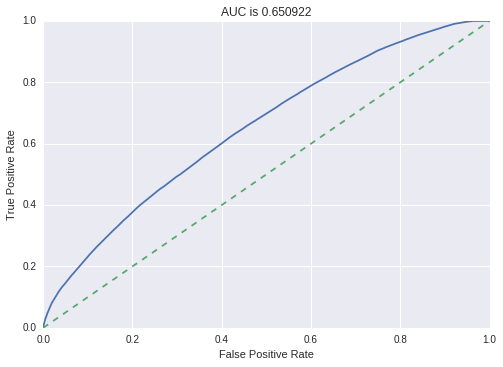

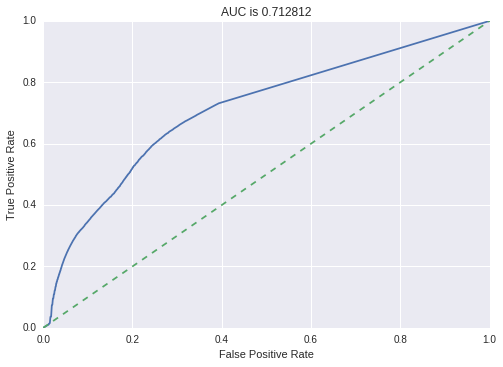

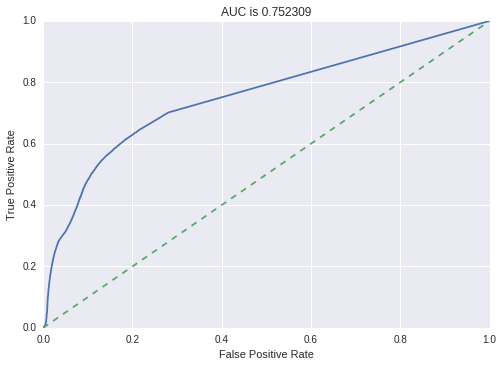

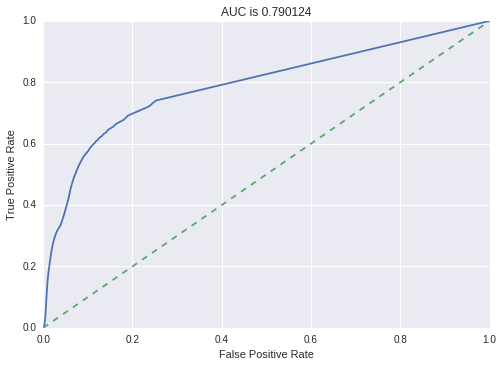

In [41]:
for i in X_dict_key:
    rf = RF(100)
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_dict[i], y, test_size = 0.4, random_state = 42)
    X_train_res_, y_train_res_ = sm.fit_sample(X_train_, y_train_)
    rf.fit(X_train_res_, y_train_res_)
    rf_pred = rf.predict(X_test_)
    pred_proba_res_rf = rf.predict_proba(X_test_)
    fpr_, tpr_, _ = roc(y_test_, pred_proba_res_rf[:,1])
    auc_ = auc(fpr_, tpr_)
    acc_ = np.mean(y_test_ == rf_pred)
    y_pred_dict[i] = rf_pred
    fpr_dict[i] = fpr_
    tpr_dict[i] = tpr_
    auc_dict[i] = auc_
    acc_dict[i] = acc_
    plt.plot(fpr_, tpr_)
    plt.plot(np.linspace(0, 1, fpr_.shape[0]), np.linspace(0, 1, fpr_.shape[0]), '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC is %f' % auc_)
    plt.show()
    
    
    
    

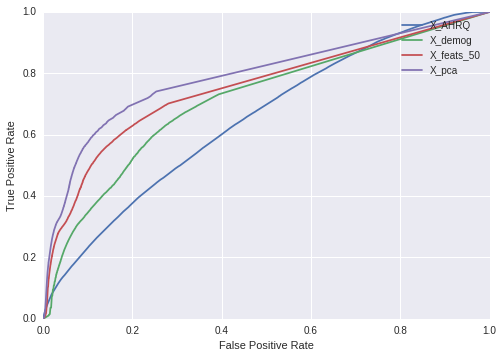

In [46]:
for i in X_dict_key:
    plt.plot(fpr_dict[i], tpr_dict[i], label = i)
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')
plt.legend()

In [54]:
acc_dict

{'X_AHRQ': 0.58323204616849322,
 'X_demog': 0.85765441574291934,
 'X_feats_50': 0.92230456610088452,
 'X_pca': 0.9369427633151729}

### PCAs

X


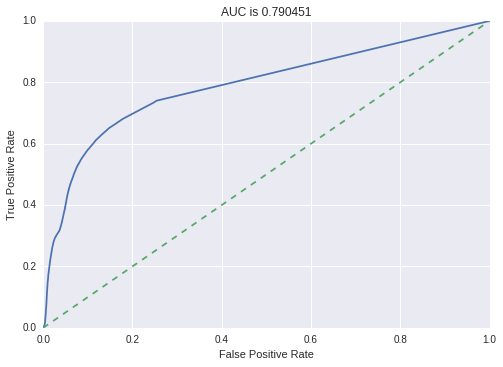

X_pca_20


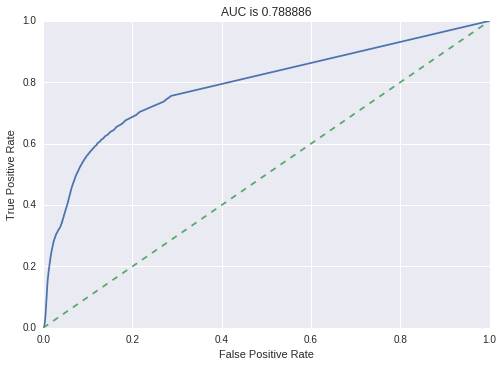

X_pca_10


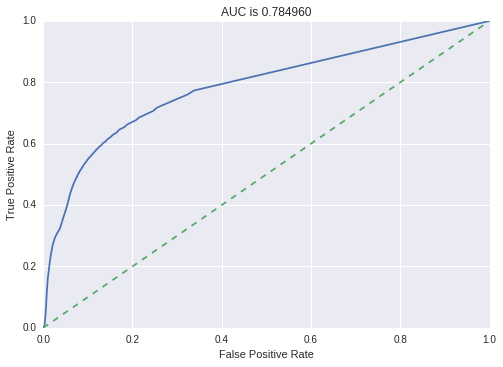

X_pca_30


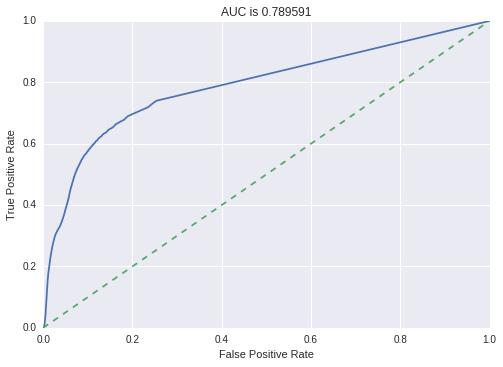

In [82]:
for i in X_pcas_key:
    print (i)
    rf = RF(100)
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_pcas[i], y, test_size = 0.4, random_state = 42)
    X_train_res_, y_train_res_ = sm.fit_sample(X_train_, y_train_)
    rf.fit(X_train_res_, y_train_res_)
    rf_pred = rf.predict(X_test_)
    pred_proba_res_rf = rf.predict_proba(X_test_)
    fpr_, tpr_, _ = roc(y_test_, pred_proba_res_rf[:,1])
    auc_ = auc(fpr_, tpr_)
    acc_ = np.mean(y_test_ == rf_pred)
    y_pred_dict[i] = rf_pred
    fpr_dict[i] = fpr_
    tpr_dict[i] = tpr_
    auc_dict[i] = auc_
    acc_dict[i] = acc_
    plt.plot(fpr_, tpr_)
    plt.plot(np.linspace(0, 1, fpr_.shape[0]), np.linspace(0, 1, fpr_.shape[0]), '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC is %f' % auc_)
    plt.show()
    
    
    
    

In [195]:
tick_label = [i for i in np.concatenate([X_dict_key, X_pcas_key]) if i != 'X_pca']

In [202]:
argsort_acc = np.argsort(np.array([acc_dict[i] for i in np.concatenate([X_dict_key, X_pcas_key]) if i != 'X_pca']))
argsort_auc = np.argsort(np.array([auc_dict[i] for i in np.concatenate([X_dict_key, X_pcas_key]) if i != 'X_pca']))

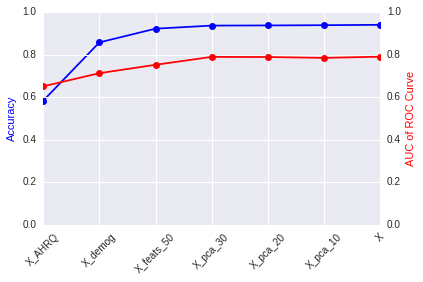

In [204]:
acc_arr = np.array([acc_dict[i] for i in np.concatenate([X_dict_key, X_pcas_key]) if i != 'X_pca'])[argsort_acc]
auc_arr = np.array([auc_dict[i] for i in np.concatenate([X_dict_key, X_pcas_key]) if i != 'X_pca'])[argsort_acc]

fig, ax1 = plt.subplots()
ax1.plot(acc_arr,'bo-')

ax1.set_xticks(np.arange(len(tick_label))[argsort_acc])
ax1.set_xticklabels(tick_label, rotation = 45)

ax1.set_ylabel('Accuracy', color='b')
ax1.set_ylim(0, 1)


ax2 = ax1.twinx()
ax2.plot(auc_arr, 'ro-')
ax2.set_ylabel('AUC of ROC Curve', color='r')
ax2.set_ylim(0, 1)
fig.tight_layout()
plt.show()

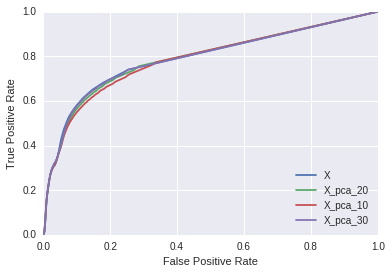

In [117]:
for i in X_pcas_key:
    plt.plot(fpr_dict[i], tpr_dict[i], label = i)
plt.legend(loc = 4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [112]:
df_acc = pd.DataFrame.from_dict(acc_dict, orient = 'index')
df_acc.columns = ['Accuracy']
df_acc['AUC'] = pd.DataFrame.from_dict(auc_dict, orient = 'index')
df_acc = df_acc.drop('X_pca')

In [205]:
df_acc.sort_values(by = 'Accuracy', axis = 0, ascending=False).to_pickle('acc_auc.pkl')

In [206]:
pd.read_pickle('acc_auc.pkl')

,Accuracy,AUC
X,0.940408,0.790451
X_pca_10,0.938742,0.784960
X_pca_20,0.937558,0.788886
X_pca_30,0.936822,0.789591
X_feats_50,0.922305,0.752309
X_demog,0.857654,0.712812
X_AHRQ,0.583232,0.650922


In [103]:
rf_cv = RF(100)

In [104]:
scores_rf_cv = cv_score(rf_cv, X_pca_10, y, cv = 5)

In [109]:
print ("Accuracy: %f (+/- %f)" % (scores_rf_cv.mean(), scores_rf_cv.std()*2))

Accuracy: 0.965187 (+/- 0.004661)


In [110]:
scores_rf_cv

array([ 0.96439895,  0.96122481,  0.96733979,  0.96529979,  0.96767364])